### Normalizing Histone Signals

In [1]:
import pandas as pd

# Load the dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_chr1.csv"
df = pd.read_csv(file_path)

# Extract histone marks columns (assuming the column names are known)
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]

# Describe the histone marks to check their distribution
histone_stats = df[histone_marks].describe()

histone_stats

,H3K4me1,H3K4me3,H3K27ac,H3K27me3,H3K9me3,H3K36me3
count,224549.000000,224549.000000,224549.000000,224549.000000,224549.000000,224549.000000
mean,1.042186,1.873665,2.227991,0.356308,0.260281,0.546310
std,4.103506,15.572536,17.754247,0.906916,0.559150,1.599200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.018803,0.056417,0.019945,0.049506,0.053842,0.049149
50%,0.060040,0.103858,0.044354,0.134022,0.119717,0.101195
75%,0.243488,0.167282,0.108863,0.308066,0.254929,0.255252
max,125.844123,585.777292,567.056822,46.514414,19.105090,55.688475


### Implementing Other Baseline Models for Chromatin Accessibility Prediction

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef, brier_score_loss, classification_report, roc_auc_score, roc_curve, fbeta_score, balanced_accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_chr1.csv"
columns = ["Chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3", "Promoter", "Intergenic", "Exon", "Intron"]
df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")

# Drop any rows where chromatin_state is NaN after conversion
df = df.dropna(subset=["chromatin_state"])

# Convert to integer type
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Undersample majority class
minority = df[df["chromatin_state"] == 1]
majority = df[df["chromatin_state"] == 0].sample(n=2000, random_state=42)  # Reduce majority to 2000 samples
df = pd.concat([minority, majority]).sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle dataset

# Print new class distribution
print("Class Distribution after Undersampling:")
print(df["chromatin_state"].value_counts())

# Extract features and target
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
annotations = ["Promoter", "Intergenic", "Exon", "Intron"]
X = df[histone_marks + annotations]
y = df["chromatin_state"]

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Normalize histone marks (fit only on training set, transform on others)
scaler = MinMaxScaler()
X_train[histone_marks] = scaler.fit_transform(X_train[histone_marks])
X_val[histone_marks] = scaler.transform(X_val[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])

# Define models
models = {
    "Histogram Gradient Boosting": HistGradientBoostingClassifier(max_depth=5, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []
roc_curves = {}
classification_threshold = 0.3  # Adjust classification threshold

for model_name, model in models.items():
    print(f"Training {model_name}...")
    fold_results = []
    all_fprs, all_tprs = [], []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        model.fit(X_fold_train, y_fold_train)
        y_pred_probs = model.predict_proba(X_fold_test)[:, 1]
        y_pred = (y_pred_probs > classification_threshold).astype(int)
        
        # Compute Metrics
        mcc = matthews_corrcoef(y_fold_test, y_pred)
        brier = brier_score_loss(y_fold_test, y_pred_probs)
        auc = roc_auc_score(y_fold_test, y_pred_probs)
        fpr, tpr, _ = roc_curve(y_fold_test, y_pred_probs)
        all_fprs.append(fpr)
        all_tprs.append(tpr)
        f2 = fbeta_score(y_fold_test, y_pred, beta=2)
        balanced_acc = balanced_accuracy_score(y_fold_test, y_pred)
        
        # Generate classification report
        class_report = classification_report(y_fold_test, y_pred, output_dict=True, zero_division=0)
        precision, recall, f1_score, support = class_report['1']['precision'], class_report['1']['recall'], class_report['1']['f1-score'], class_report['1']['support']
        
        fold_results.append({
            "Model": model_name,
            "Fold": fold + 1,
            "MCC": mcc,
            "Brier Score": brier,
            "AUC": auc,
            "FPR (1-Specificity)": fpr.mean(),
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1_score,
            "F2 Score": f2,
            "Balanced Accuracy": balanced_acc,
            "Support": support
        })
    
    results.extend(fold_results)
    roc_curves[model_name] = (all_fprs, all_tprs)

    # Test model on the holdout test set
    print(f"Evaluating {model_name} on Test Set...")
    y_test_probs = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_probs > classification_threshold).astype(int)
    
    test_auc = roc_auc_score(y_test, y_test_probs)
    test_mcc = matthews_corrcoef(y_test, y_test_pred)
    print(f"Test AUC: {test_auc:.4f}, Test MCC: {test_mcc:.4f}")
    print(classification_report(y_test, y_test_pred, zero_division=0))

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_34102/1155626865.py:14: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Class Distribution after Undersampling:
chromatin_state
0    2000
1     403
Name: count, dtype: int64
Training Histogram Gradient Boosting...
Evaluating Histogram Gradient Boosting on Test Set...
Test AUC: 0.9904, Test MCC: 0.8853
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       300
           1       0.88      0.93      0.90        61

    accuracy                           0.97       361
   macro avg       0.93      0.95      0.94       361
weighted avg       0.97      0.97      0.97       361

Training Logistic Regression...
Evaluating Logistic Regression on Test Set...
Test AUC: 0.9881, Test MCC: 0.8220
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       300
           1       0.78      0.93      0.85        61

    accuracy                           0.94       361
   macro avg       0.88      0.94      0.91       361
weighted avg       0.95      0.94      0.95       361

Tr

### Results

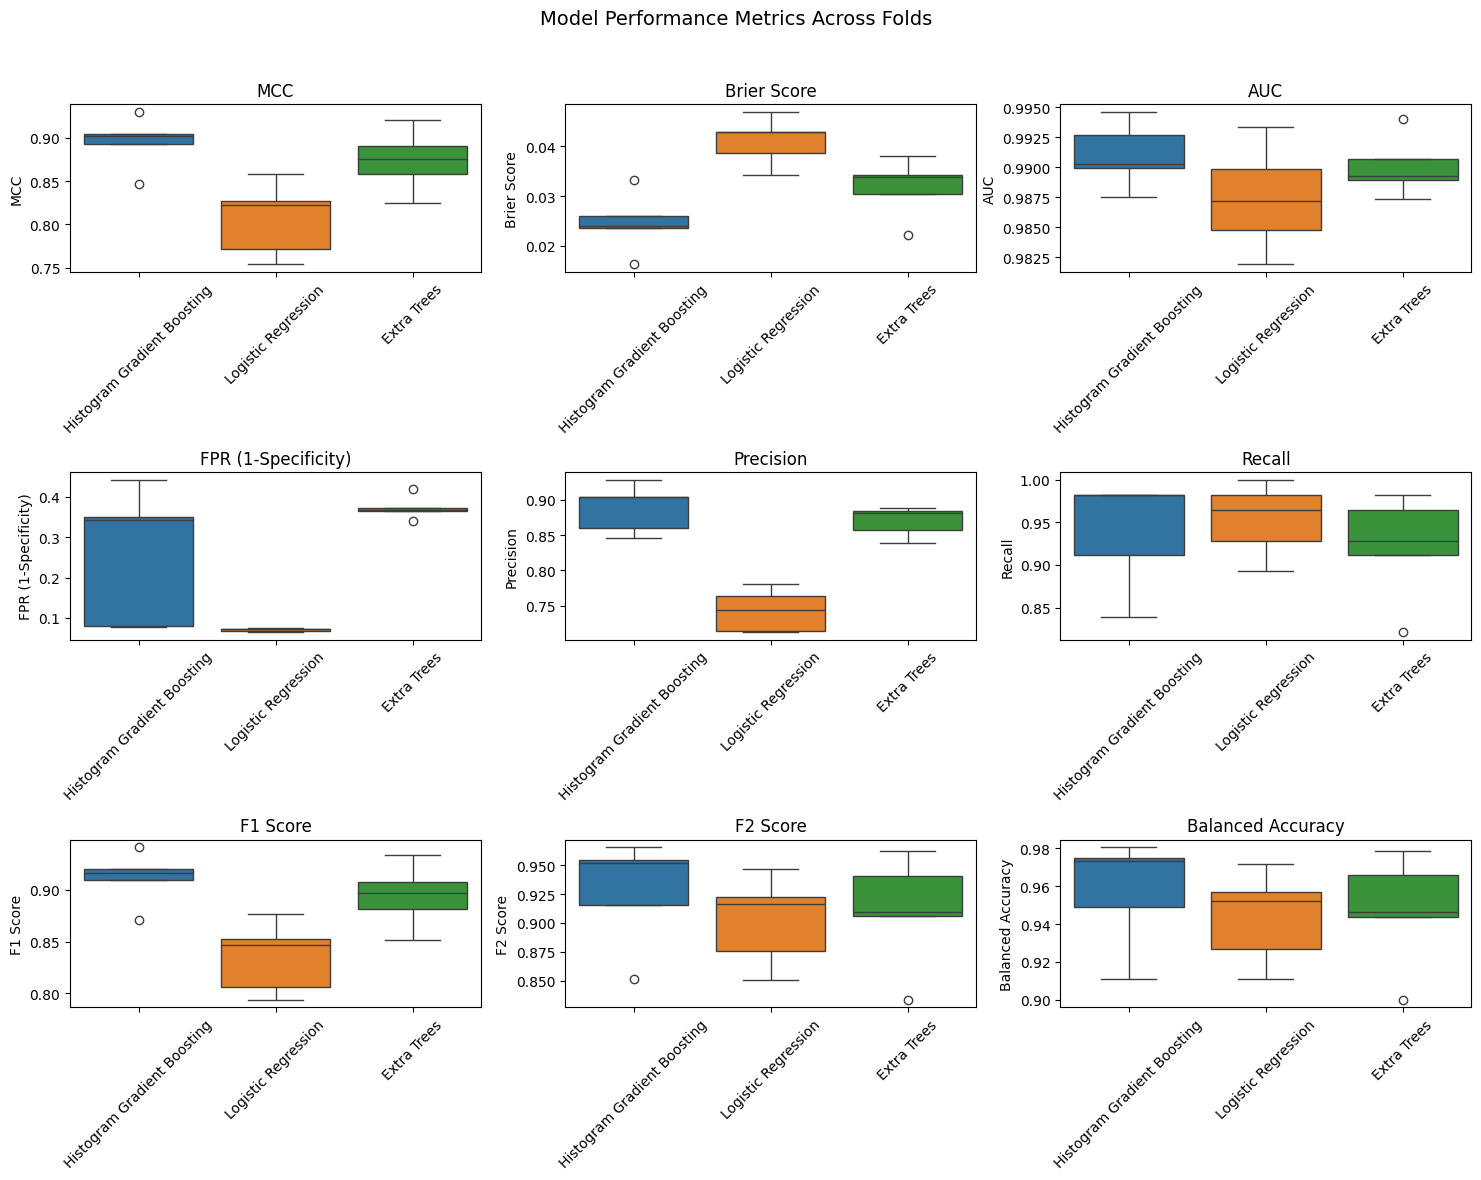

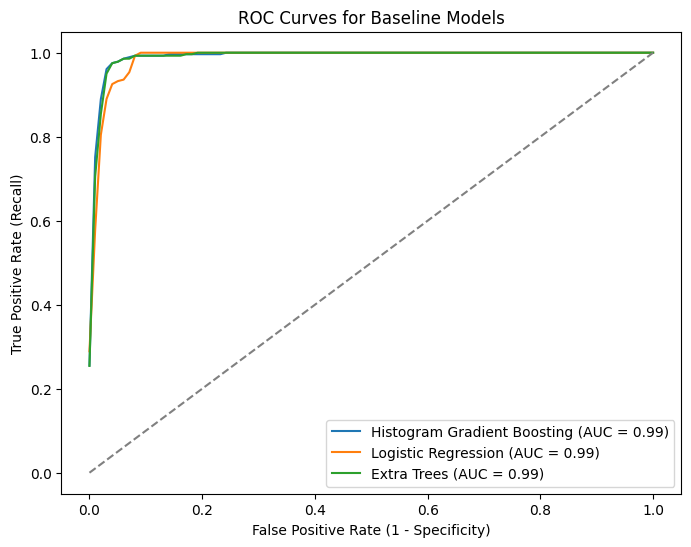

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualizing the results of model performance metrics
metrics = ["MCC", "Brier Score", "AUC", "FPR (1-Specificity)", "Precision", "Recall", "F1 Score", "F2 Score", "Balanced Accuracy"]

# Set up figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Model Performance Metrics Across Folds", fontsize=14)

# Generate plots for each metric
for ax, metric in zip(axes.flatten(), metrics):
    sns.boxplot(data=results_df, x="Model", y=metric, ax=ax, hue="Model")
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels to prevent overlap

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot ROC Curves for each model
plt.figure(figsize=(8, 6))
for model_name, (all_fprs, all_tprs) in roc_curves.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fprs, all_tprs)], axis=0)
    plt.plot(mean_fpr, mean_tpr, label=f"{model_name} (AUC = {np.mean([auc for auc in results_df[results_df['Model'] == model_name]['AUC']]):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves for Baseline Models")
plt.legend()
plt.show()

### Multihead Neural Network (Train and Validation)

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_34102/2963704799.py:17: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Training Fold 1/3
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4596 - loss: 0.7198 - val_accuracy: 0.9338 - val_loss: 0.4473
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9208 - loss: 0.3697 - val_accuracy: 0.9638 - val_loss: 0.1413
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9503 - loss: 0.1781 - val_accuracy: 0.9663 - val_loss: 0.1055
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9568 - loss: 0.1361 - val_accuracy: 0.9775 - val_loss: 0.0998
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9609 - loss: 0.1187 - val_accuracy: 0.9750 - val_loss: 0.0885
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9587 - loss: 0.1346 - val_accuracy: 0.9750 - val_loss: 0.0845
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9729 - loss: 0.0961 - val_accuracy: 0.9763 - val_loss: 0.0814
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9652 - loss: 0.0986 - val_accuracy: 

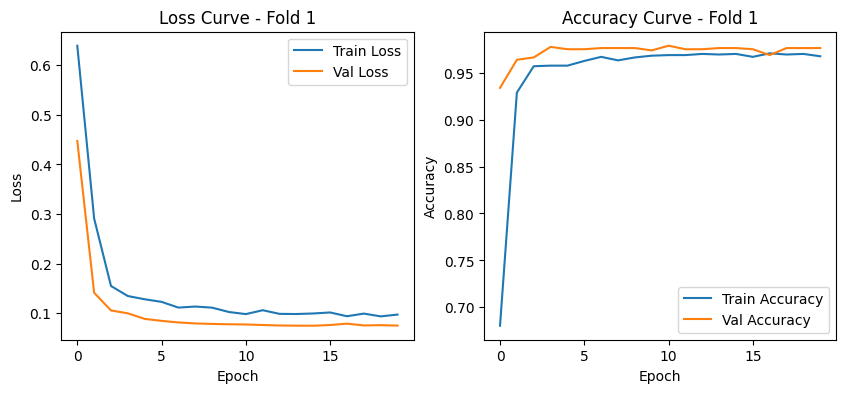

Training Fold 2/3
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7444 - loss: 0.6148 - val_accuracy: 0.8801 - val_loss: 0.3365
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8849 - loss: 0.2936 - val_accuracy: 0.9376 - val_loss: 0.1646
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9566 - loss: 0.1448 - val_accuracy: 0.9551 - val_loss: 0.1174
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9672 - loss: 0.1105 - val_accuracy: 0.9613 - val_loss: 0.1084
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9699 - loss: 0.0995 - val_accuracy: 0.9600 - val_loss: 0.1105
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9717 - loss: 0.0985 - val_accuracy: 0.9625 - val_loss: 0.1055
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9724 - loss: 0.0992 - val_accuracy: 0.9625 - val_loss: 0.1027
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9708 - loss: 0.0938 - val_accuracy: 

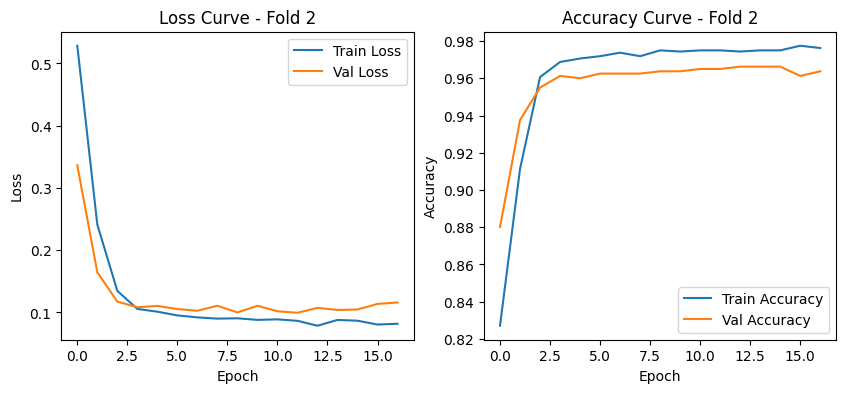

Training Fold 3/3
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7244 - loss: 0.6064 - val_accuracy: 0.8589 - val_loss: 0.3135
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8757 - loss: 0.2982 - val_accuracy: 0.9476 - val_loss: 0.1590
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9501 - loss: 0.1427 - val_accuracy: 0.9638 - val_loss: 0.1117
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9579 - loss: 0.1365 - val_accuracy: 0.9713 - val_loss: 0.0990
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9689 - loss: 0.1007 - val_accuracy: 0.9738 - val_loss: 0.0968
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9722 - loss: 0.0861 - val_accuracy: 0.9725 - val_loss: 0.0948
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9679 - loss: 0.0960 - val_accuracy: 0.9725 - val_loss: 0.0947
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9708 - loss: 0.0904 - val_accuracy: 

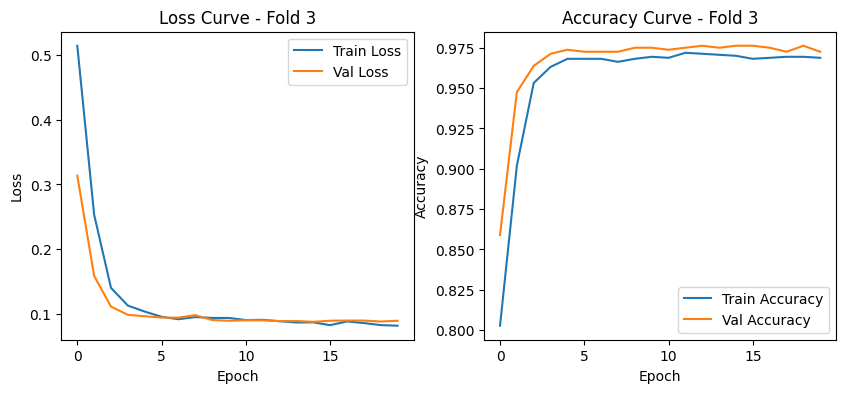

Cross-validation complete!


In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_chr1.csv"
columns = ["Chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3", "Promoter", "Intergenic", "Exon", "Intron"]
df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Undersample majority class for training
df_majority = df[df["chromatin_state"] == 0].sample(n=2000, random_state=42)
df_minority = df[df["chromatin_state"] == 1]
df_balanced = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42)

# Extract features and target
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
annotations = ["Promoter", "Intergenic", "Exon", "Intron"]
X_histone = df_balanced[histone_marks]
X_annotations = df_balanced[annotations]
y = df_balanced["chromatin_state"]

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_histone, y)):
    print(f"Training Fold {fold + 1}/3")
    
    # Split the data into training and validation sets
    X_hist_train, X_hist_val = X_histone.iloc[train_idx], X_histone.iloc[val_idx]
    X_anno_train, X_anno_val = X_annotations.iloc[train_idx].values.astype(np.float32), X_annotations.iloc[val_idx].values.astype(np.float32)
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Normalize histone marks (fit only on training set)
    scaler = MinMaxScaler()
    X_hist_train = scaler.fit_transform(X_hist_train.values)
    X_hist_val = scaler.transform(X_hist_val.values)
    
    # Define Neural Network Model
    histone_input = Input(shape=(X_hist_train.shape[1],), name="Histone_Input")
    histone_dense = Dense(64, activation='relu')(histone_input)
    histone_dense = Dropout(0.3)(histone_dense)
    histone_dense = Dense(32, activation='relu')(histone_dense)
    
    annotation_input = Input(shape=(X_anno_train.shape[1],), name="Annotation_Input")
    annotation_dense = Dense(32, activation='relu')(annotation_input)
    annotation_dense = Dropout(0.3)(annotation_dense)
    
    merged = Concatenate()([histone_dense, annotation_dense])
    final_dense = Dense(32, activation='relu')(merged)
    final_dense = Dropout(0.3)(final_dense)
    out = Dense(1, activation='sigmoid', name="Output")(final_dense)
    
    model = Model(inputs=[histone_input, annotation_input], outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit([X_hist_train, X_anno_train], y_train, epochs=50, batch_size=32, validation_data=([X_hist_val, X_anno_val], y_val), callbacks=[early_stopping])
    
    # Store training history
    fold_results.append(history.history)
    
    # Plot training loss and accuracy for each fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curve - Fold {fold + 1}')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Accuracy Curve - Fold {fold + 1}')
    
    plt.show()
    
print("Cross-validation complete!")

### Multihead Neural Network (Train, Validation and Test)

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_34102/182635860.py:17: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Training Fold 1/5
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7703 - loss: 0.5824 - val_accuracy: 0.8902 - val_loss: 0.3003
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8883 - loss: 0.2892 - val_accuracy: 0.9703 - val_loss: 0.1280
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9400 - loss: 0.1699 - val_accuracy: 0.9763 - val_loss: 0.0710
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9581 - loss: 0.1151 - val_accuracy: 0.9763 - val_loss: 0.0668
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9562 - loss: 0.1173 - val_accuracy: 0.9822 - val_loss: 0.0651
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9608 - loss: 0.1223 - val_accuracy: 0.9822 - val_loss: 0.0602
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9658 - loss: 0.1044 - val_accuracy: 0.9792 - val_loss: 0.0639
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9647 - loss: 0.1206 - val_accuracy: 

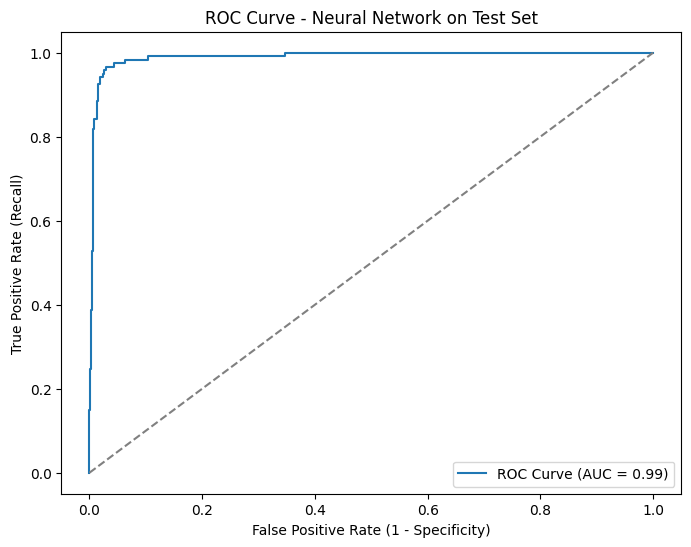

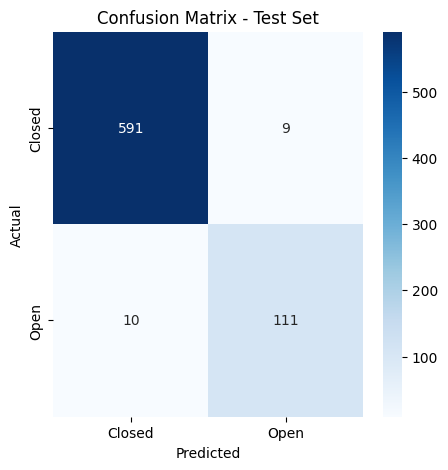

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_chr1.csv"
columns = ["Chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3", "Promoter", "Intergenic", "Exon", "Intron"]
df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Undersample majority class for training
df_majority = df[df["chromatin_state"] == 0].sample(n=2000, random_state=42)
df_minority = df[df["chromatin_state"] == 1]
df_balanced = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42)

# Extract features and target
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
annotations = ["Promoter", "Intergenic", "Exon", "Intron"]
X_histone = df_balanced[histone_marks]
X_annotations = df_balanced[annotations]
y = df_balanced["chromatin_state"]

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_histone, y, test_size=0.30, random_state=42, stratify=y)
X_anno_train, X_anno_test = train_test_split(X_annotations, test_size=0.30, random_state=42, stratify=y)

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"Training Fold {fold + 1}/5")
    
    # Split the data into training and validation sets
    X_hist_train, X_hist_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    X_anno_train_fold, X_anno_val = X_anno_train.iloc[train_idx].values.astype(np.float32), X_anno_train.iloc[val_idx].values.astype(np.float32)
    y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Normalize histone marks (fit only on training set)
    scaler = MinMaxScaler()
    X_hist_train = scaler.fit_transform(X_hist_train.values)
    X_hist_val = scaler.transform(X_hist_val.values)
    
    # Define Neural Network Model
    histone_input = Input(shape=(X_hist_train.shape[1],), name="Histone_Input")
    histone_dense = Dense(64, activation='relu')(histone_input)
    histone_dense = Dropout(0.3)(histone_dense)
    histone_dense = Dense(32, activation='relu')(histone_dense)
    
    annotation_input = Input(shape=(X_anno_train_fold.shape[1],), name="Annotation_Input")
    annotation_dense = Dense(32, activation='relu')(annotation_input)
    annotation_dense = Dropout(0.3)(annotation_dense)
    
    merged = Concatenate()([histone_dense, annotation_dense])
    final_dense = Dense(32, activation='relu')(merged)
    final_dense = Dropout(0.3)(final_dense)
    out = Dense(1, activation='sigmoid', name="Output")(final_dense)
    
    model = Model(inputs=[histone_input, annotation_input], outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit([X_hist_train, X_anno_train_fold], y_train_fold, epochs=50, batch_size=32, validation_data=([X_hist_val, X_anno_val], y_val), callbacks=[early_stopping])
    
    # Store training history
    fold_results.append(history.history)

# Test Set Performance Metrics
X_hist_test = scaler.transform(X_test.values)
X_anno_test = X_anno_test.values.astype(np.float32)

y_test_probs = model.predict([X_hist_test, X_anno_test])
y_test_pred = (y_test_probs > 0.5).astype(int)

# Convert test labels to NumPy arrays before logical operations
y_test_pred = np.array(y_test_pred).flatten()
y_test = np.array(y_test).flatten()

# Compute Final Test Set Metrics
test_auc = roc_auc_score(y_test, y_test_probs)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_mcc = matthews_corrcoef(y_test, y_test_pred)
test_fpr = np.sum((y_test_pred == 1) & (y_test == 0)) / np.sum(y_test == 0)

# Print Metrics
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test MCC: {test_mcc:.4f}")
print(f"Test FPR (1 - Specificity): {test_fpr:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Neural Network on Test Set")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_34102/182635860.py:17: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Training Fold 1/5
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8156 - loss: 0.6162 - val_accuracy: 0.8665 - val_loss: 0.4093
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8736 - loss: 0.3851 - val_accuracy: 0.9763 - val_loss: 0.1487
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9399 - loss: 0.1828 - val_accuracy: 0.9792 - val_loss: 0.0761
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9631 - loss: 0.1356 - val_accuracy: 0.9733 - val_loss: 0.0624
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9540 - loss: 0.1571 - val_accuracy: 0.9763 - val_loss: 0.0593
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9571 - loss: 0.1263 - val_accuracy: 0.9763 - val_loss: 0.0573
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9630 - loss: 0.1458 - val_accuracy: 0.9792 - val_loss: 0.0567
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9687 - loss: 0.1065 - val_accuracy: 

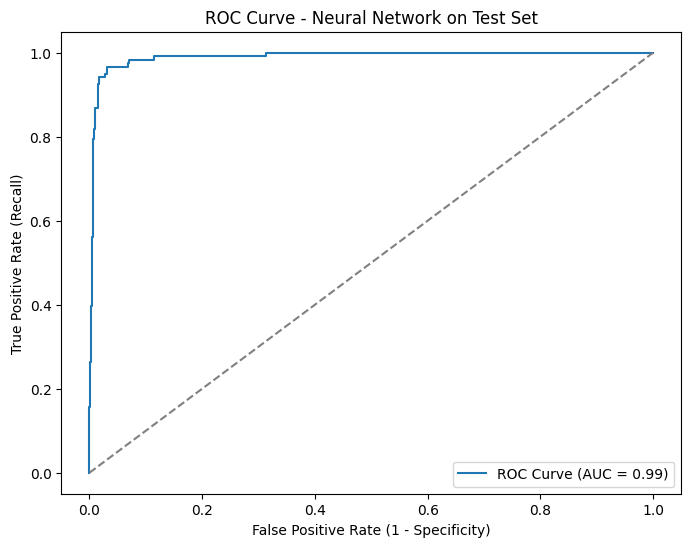

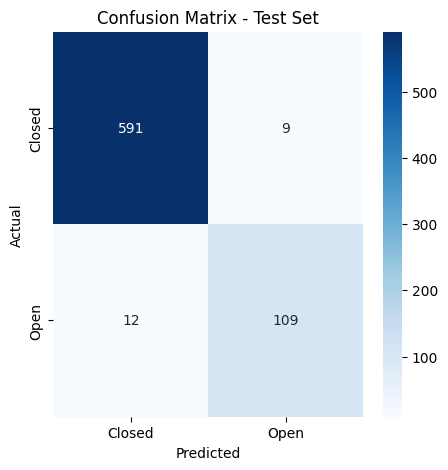

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_chr1.csv"
columns = ["Chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3", "Promoter", "Intergenic", "Exon", "Intron"]
df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Undersample majority class for training
df_majority = df[df["chromatin_state"] == 0].sample(n=2000, random_state=42)
df_minority = df[df["chromatin_state"] == 1]
df_balanced = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42)

# Extract features and target
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
annotations = ["Promoter", "Intergenic", "Exon", "Intron"]
X_histone = df_balanced[histone_marks]
X_annotations = df_balanced[annotations]
y = df_balanced["chromatin_state"]

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_histone, y, test_size=0.30, random_state=42, stratify=y)
X_anno_train, X_anno_test = train_test_split(X_annotations, test_size=0.30, random_state=42, stratify=y)

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"Training Fold {fold + 1}/5")
    
    # Split the data into training and validation sets
    X_hist_train, X_hist_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    X_anno_train_fold, X_anno_val = X_anno_train.iloc[train_idx].values.astype(np.float32), X_anno_train.iloc[val_idx].values.astype(np.float32)
    y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Normalize histone marks (fit only on training set)
    scaler = MinMaxScaler()
    X_hist_train = scaler.fit_transform(X_hist_train.values)
    X_hist_val = scaler.transform(X_hist_val.values)
    
    # Define Neural Network Model
    histone_input = Input(shape=(X_hist_train.shape[1],), name="Histone_Input")
    histone_dense = Dense(64, activation='relu')(histone_input)
    histone_dense = Dropout(0.3)(histone_dense)
    histone_dense = Dense(32, activation='relu')(histone_dense)
    
    annotation_input = Input(shape=(X_anno_train_fold.shape[1],), name="Annotation_Input")
    annotation_dense = Dense(32, activation='relu')(annotation_input)
    annotation_dense = Dropout(0.3)(annotation_dense)
    
    merged = Concatenate()([histone_dense, annotation_dense])
    final_dense = Dense(32, activation='relu')(merged)
    final_dense = Dropout(0.3)(final_dense)
    out = Dense(1, activation='sigmoid', name="Output")(final_dense)
    
    model = Model(inputs=[histone_input, annotation_input], outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit([X_hist_train, X_anno_train_fold], y_train_fold, epochs=50, batch_size=32, validation_data=([X_hist_val, X_anno_val], y_val), callbacks=[early_stopping])
    
    # Store training history
    fold_results.append(history.history)

# Test Set Performance Metrics
X_hist_test = scaler.transform(X_test.values)
X_anno_test = X_anno_test.values.astype(np.float32)

y_test_probs = model.predict([X_hist_test, X_anno_test])
y_test_pred = (y_test_probs > 0.5).astype(int)

# Convert test labels to NumPy arrays before logical operations
y_test_pred = np.array(y_test_pred).flatten()
y_test = np.array(y_test).flatten()

# Compute Final Test Set Metrics
test_auc = roc_auc_score(y_test, y_test_probs)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_mcc = matthews_corrcoef(y_test, y_test_pred)
test_fpr = np.sum((y_test_pred == 1) & (y_test == 0)) / np.sum(y_test == 0)

# Print Metrics
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test MCC: {test_mcc:.4f}")
print(f"Test FPR (1 - Specificity): {test_fpr:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Neural Network on Test Set")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

New Shape of SHAP Values: (721, 10)


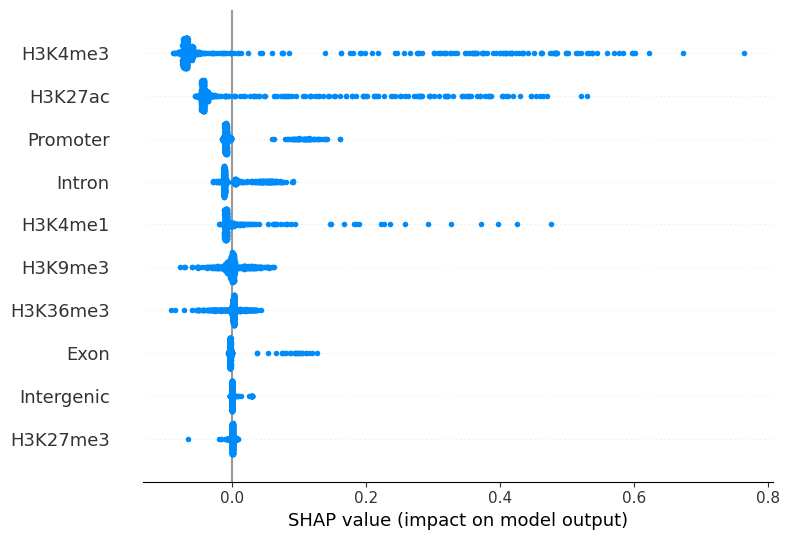

In [40]:
import shap
import numpy as np

# Reshape SHAP values to remove the last singleton dimension
shap_values_combined = shap_values_combined.squeeze(axis=-1)

# Debugging Output
print("New Shape of SHAP Values:", shap_values_combined.shape)  # Should be (721, 10)

# Ensure feature names length matches SHAP output
assert shap_values_combined.shape[1] == len(feature_names_combined), "SHAP feature count mismatch!"

# SHAP Summary Plot
shap.summary_plot(shap_values_combined, feature_names=feature_names_combined)

#### How to Read the Plot:
- **X-Axis:** SHAP values (positive → increases probability of open chromatin, negative → decreases).  
- **Y-Axis:** Features ranked by importance.  
- **Density of dots:** More dots indicate more samples where that feature has an effect.  

#### Key Takeaways:
- H3K4me3 and H3K27ac are the strongest predictors of open chromatin.  
- Histone modifications are more influential than genomic annotations.
- Repressive marks (H3K27me3) contribute little** to predicting open states.  
- Promoters contribute to chromatin accessibility predictions, supporting their role in gene regulation.